In [16]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from ae_model import Autoencoder
from sklearn.decomposition import PCA

The autoencoder model is pre-trained from previous project: [interactive_denoiser](https://github.com/ShlomiRex/interactive_denoiser)

Its simple autoencoder with 3 CNN layers (and the decoder is the reverse of the encoder).

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
# Load the pretrained model
model = Autoencoder(128)
model.load_state_dict(torch.load("ae_model.pth", map_location=device))

# Set the model to evaluation mode
model.to(device)
model.eval()

C:\Users\Shlomi\AppData\Local\Temp\ipykernel_28140\3187823911.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_model.pth", map_locati

Autoencoder(
  (enc_conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu1): ReLU()
  (enc_conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu2): ReLU()
  (enc_conv3): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
  (enc_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_conv1): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (dec_relu1): ReLU()
  (dec_conv2): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu2): ReLU()
  (dec_conv3): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_tanh): Tanh()
)

In [19]:
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
print(f"Dataset size: {len(dataset)}")

Dataset size: 10000


# View latent space of autoencoder

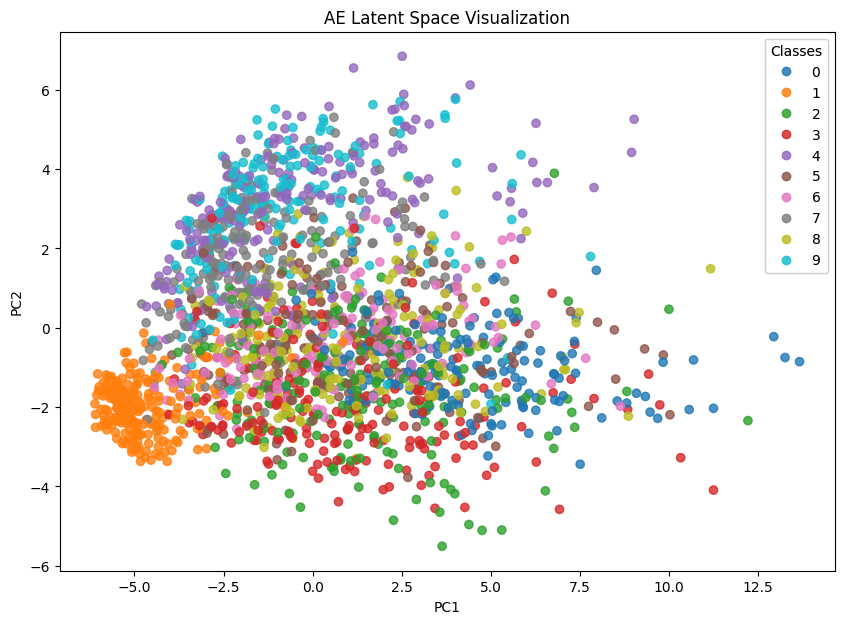

In [20]:
# Extract latent vectors from a subset of the test set
def extract_latent_vectors(loader, num_samples=500):
    latent_vectors = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            latent = model.encode(images).view(images.size(0), -1)  # Flatten latent space

            latent_vectors.append(latent.cpu())
            labels.append(targets)
            count += images.size(0)

            if count >= num_samples:  # Stop after collecting enough samples
                break

    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    return latent_vectors.numpy(), labels.numpy()

# Visualize the latent space
def plot_latent_space(latent_2d, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
    ax.set_title('AE Latent Space Visualization')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Add legend
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend)

    plt.show()


num_samples = 2_000
latent_vectors, labels = extract_latent_vectors(dataset_loader, num_samples)

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)
plot_latent_space(latent_2d, labels)

The PCA analysis tells us the model is not learning the latent space well.

# Sample random latent vectors

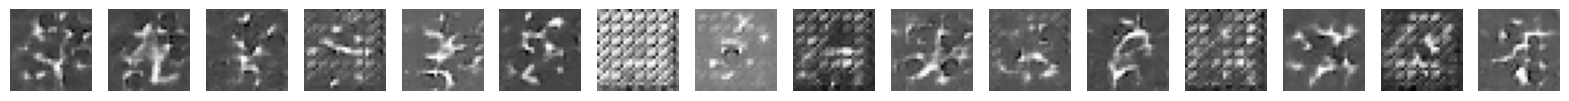

In [21]:
# Sample random latent vectors and decode them
n_samples = 16
latent_samples = torch.randn(n_samples, 128).to(device)
reconstructed_samples = model.decode(latent_samples).cpu()

# Visualize the reconstructed samples
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))

for i in range(n_samples):
    axes[i].imshow(reconstructed_samples[i].view(28, 28).detach().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()

## This is not VAE. This is AE. Every image is mapped to fixed latent vector. We can't interpolate between latent vectors. This is where Variational Autoencoder comes into play.

<img src="img.jpg" alt="Drawing" style="width: 800px;"/>

In [22]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
import math

Define the VAE model. All of the layers are exactly the same as the autoencoder model, except the latent space is now a distribution.

I also added fc_mu and fc_logvar layers. These layers are responsible for generating the latent space distribution.

We added sample method which takes in mean and logvar and samples from the distribution.

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.image_width = int(math.sqrt(input_dim))
        self.image_height = int(math.sqrt(input_dim))

        self.__setup_encoder()
        self.__setup_decoder()
    
    def __setup_encoder(self):
        self.enc_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.enc_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)

        self.relu = nn.ReLU()

        # Now we have two layers for each vector in latent space (going from hidden_dim to latent_dim)
        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)  # Mean vector
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)  # Log-variance vector

    def __setup_decoder(self):
        self.dec_fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.dec_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.dec_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
    
    def encode(self, x):
        x = rearrange(x, 'b c h w -> b (c h w)') # Flatten the input
        x = self.relu(self.enc_fc1(x))
        x = self.relu(self.enc_fc2(x))

        mean = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # Here we don't return x, we return mean and log_var, this is different to AE
        return mean, log_var
    
    def decode(self, latent):
        x = self.relu(self.dec_fc1(latent))
        x = self.relu(self.dec_fc2(x))

        x_hat = torch.sigmoid(self.dec_fc3(x))

        x_hat = rearrange(x_hat, 'b (c h w) -> b c h w', c=1, h=self.image_width, w=self.image_height) # Reshape the output

        return x_hat
    
    def reparameterization(self, mean, var):
        """
        Variance is exponential of log_var
        """
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z


    def forward(self, x):
        assert x.shape[-3:] == (1, 28, 28)

        # Encode - instead of latent vector we get mean and log_var (look at image!)
        mean, log_var = self.encode(x)

        # Here is the magic of VAE
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        
        # Decode
        x_reconstructed = self.decode(z)

        # Return x hat
        return x_reconstructed, mean, log_var

In [24]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss
    # recon_loss = nn.MSELoss()(x_hat, x)
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [25]:
input_dim = 1 * 28 * 28
hidden_dim = 400
latent_dim = 200

vae = VariationalAutoencoder(input_dim, hidden_dim, latent_dim)
vae.to(device)

summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
              ReLU-2                  [-1, 400]               0
            Linear-3                  [-1, 400]         160,400
              ReLU-4                  [-1, 400]               0
            Linear-5                  [-1, 200]          80,200
            Linear-6                  [-1, 200]          80,200
            Linear-7                  [-1, 400]          80,400
              ReLU-8                  [-1, 400]               0
            Linear-9                  [-1, 400]         160,400
             ReLU-10                  [-1, 400]               0
           Linear-11                  [-1, 784]         314,384
Total params: 1,189,984
Trainable params: 1,189,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

The VAE model has similar parameter count as the base autoencoder model.

The base AE model has 5,614,465 parameters.

Here we have 1.189M parameters, which is significantly less.

# Without training, see the VAE reconstruction

In [26]:
del model # We don't need the AE model anymore
model = None
model = vae

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [27]:
# Transformations: Normalize and convert to tensor
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])  # See what happens if we dont normalize

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## See what happens when we try to reconstruct without training.

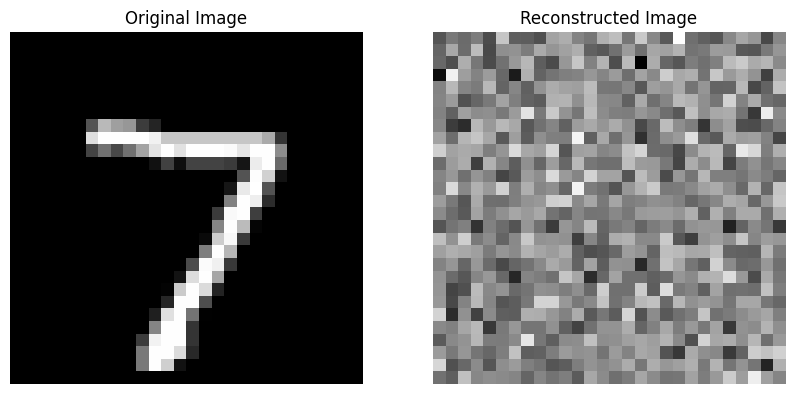

In [28]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


The model is not trained so its not surprising that the reconstruction is bad.

# Train the model on MNIST dataset

In [29]:
from tqdm import tqdm
import cv2
import numpy as np

In [30]:
# Training loop
num_epochs = 20

loss_history = []
kl_divergence_history = []
recon_loss_history = []

for epoch in range(num_epochs):
    model.train()

    overall_loss = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            x_hat, mean, log_var = model(images)

            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

            # Add all three losses to history
            loss_history.append(loss.item())
            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())

            overall_loss += loss.item()

            # Propagate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            t.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
    print("Average loss: ", overall_loss / len(train_loader))





Epoch [1/20]: 100%|██████████| 3750/3750 [00:28<00:00, 132.11it/s, kl_loss=246, loss=2.15e+3, recon_loss=1.9e+3] 


Epoch [1/20], Recon Loss: 2305.4192, KL Loss: 201.0205
Average loss:  2506.439683496094


Epoch [2/20]: 100%|██████████| 3750/3750 [00:27<00:00, 135.06it/s, kl_loss=268, loss=2e+3, recon_loss=1.73e+3]   


Epoch [2/20], Recon Loss: 2033.1250, KL Loss: 223.3419
Average loss:  2006.4942122395832


Epoch [3/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.55it/s, kl_loss=248, loss=1.85e+3, recon_loss=1.6e+3] 


Epoch [3/20], Recon Loss: 1900.4286, KL Loss: 234.4256
Average loss:  1891.6287575846354


Epoch [4/20]: 100%|██████████| 3750/3750 [00:28<00:00, 132.97it/s, kl_loss=274, loss=1.9e+3, recon_loss=1.62e+3] 


Epoch [4/20], Recon Loss: 1822.2840, KL Loss: 241.4492
Average loss:  1850.3697923177083


Epoch [5/20]: 100%|██████████| 3750/3750 [00:28<00:00, 133.18it/s, kl_loss=264, loss=2.01e+3, recon_loss=1.75e+3]


Epoch [5/20], Recon Loss: 1769.1940, KL Loss: 246.5222
Average loss:  1823.6483666992187


Epoch [6/20]: 100%|██████████| 3750/3750 [00:27<00:00, 137.50it/s, kl_loss=273, loss=1.67e+3, recon_loss=1.4e+3] 


Epoch [6/20], Recon Loss: 1730.7998, KL Loss: 250.5082
Average loss:  1809.2675270507812


Epoch [7/20]: 100%|██████████| 3750/3750 [00:27<00:00, 138.16it/s, kl_loss=284, loss=1.81e+3, recon_loss=1.53e+3]


Epoch [7/20], Recon Loss: 1701.3854, KL Loss: 253.5327
Average loss:  1796.5784612304687


Epoch [8/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.46it/s, kl_loss=284, loss=1.95e+3, recon_loss=1.67e+3]


Epoch [8/20], Recon Loss: 1677.9817, KL Loss: 256.1084
Average loss:  1788.29408828125


Epoch [9/20]: 100%|██████████| 3750/3750 [00:27<00:00, 137.19it/s, kl_loss=284, loss=1.88e+3, recon_loss=1.6e+3] 


Epoch [9/20], Recon Loss: 1658.3834, KL Loss: 258.3173
Average loss:  1777.5857780598958


Epoch [10/20]: 100%|██████████| 3750/3750 [00:27<00:00, 135.31it/s, kl_loss=289, loss=1.79e+3, recon_loss=1.5e+3] 


Epoch [10/20], Recon Loss: 1641.3920, KL Loss: 260.3613
Average loss:  1767.2258751302084


Epoch [11/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.69it/s, kl_loss=273, loss=1.85e+3, recon_loss=1.57e+3]


Epoch [11/20], Recon Loss: 1626.6635, KL Loss: 262.1871
Average loss:  1759.825055859375


Epoch [12/20]: 100%|██████████| 3750/3750 [00:27<00:00, 137.84it/s, kl_loss=275, loss=1.79e+3, recon_loss=1.52e+3]


Epoch [12/20], Recon Loss: 1613.7412, KL Loss: 263.8448
Average loss:  1753.6744459960937


Epoch [13/20]: 100%|██████████| 3750/3750 [00:28<00:00, 129.80it/s, kl_loss=286, loss=1.75e+3, recon_loss=1.47e+3]


Epoch [13/20], Recon Loss: 1602.3905, KL Loss: 265.3044
Average loss:  1749.0020506835938


Epoch [14/20]: 100%|██████████| 3750/3750 [00:34<00:00, 108.90it/s, kl_loss=280, loss=1.8e+3, recon_loss=1.52e+3] 


Epoch [14/20], Recon Loss: 1592.2593, KL Loss: 266.6400
Average loss:  1744.5571755533854


Epoch [15/20]: 100%|██████████| 3750/3750 [00:28<00:00, 129.89it/s, kl_loss=293, loss=1.81e+3, recon_loss=1.51e+3]


Epoch [15/20], Recon Loss: 1583.1864, KL Loss: 267.8219
Average loss:  1740.5336518229167


Epoch [16/20]: 100%|██████████| 3750/3750 [00:28<00:00, 132.04it/s, kl_loss=289, loss=1.91e+3, recon_loss=1.62e+3]


Epoch [16/20], Recon Loss: 1575.0162, KL Loss: 268.8975
Average loss:  1737.4934200520834


Epoch [17/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.91it/s, kl_loss=307, loss=1.69e+3, recon_loss=1.38e+3]


Epoch [17/20], Recon Loss: 1567.5994, KL Loss: 269.8870
Average loss:  1734.650139485677


Epoch [18/20]: 100%|██████████| 3750/3750 [00:26<00:00, 139.58it/s, kl_loss=288, loss=1.73e+3, recon_loss=1.44e+3]


Epoch [18/20], Recon Loss: 1560.8290, KL Loss: 270.7878
Average loss:  1731.8342524088541


Epoch [19/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.93it/s, kl_loss=305, loss=1.82e+3, recon_loss=1.51e+3]


Epoch [19/20], Recon Loss: 1554.6132, KL Loss: 271.6177
Average loss:  1729.2833837239584


Epoch [20/20]: 100%|██████████| 3750/3750 [00:29<00:00, 129.07it/s, kl_loss=276, loss=1.55e+3, recon_loss=1.27e+3]


Epoch [20/20], Recon Loss: 1548.8470, KL Loss: 272.4120
Average loss:  1726.7951786458334


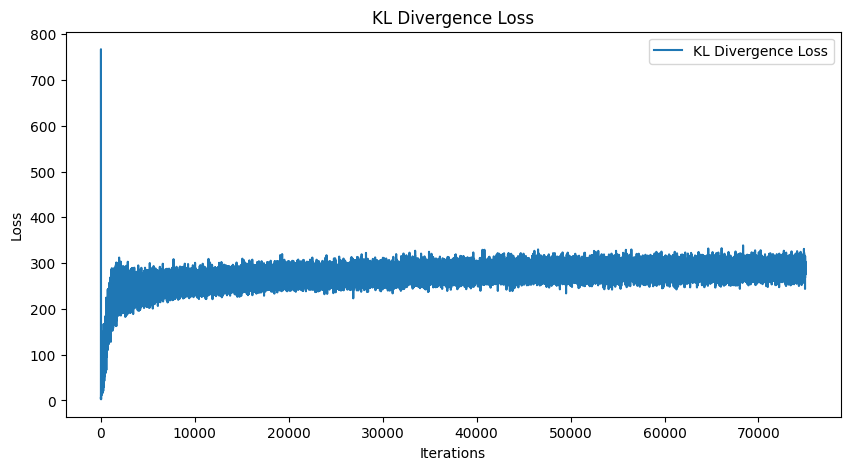

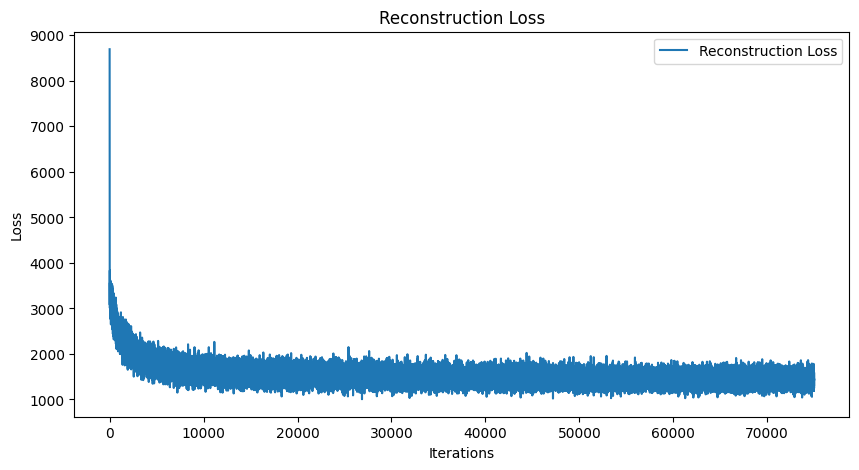

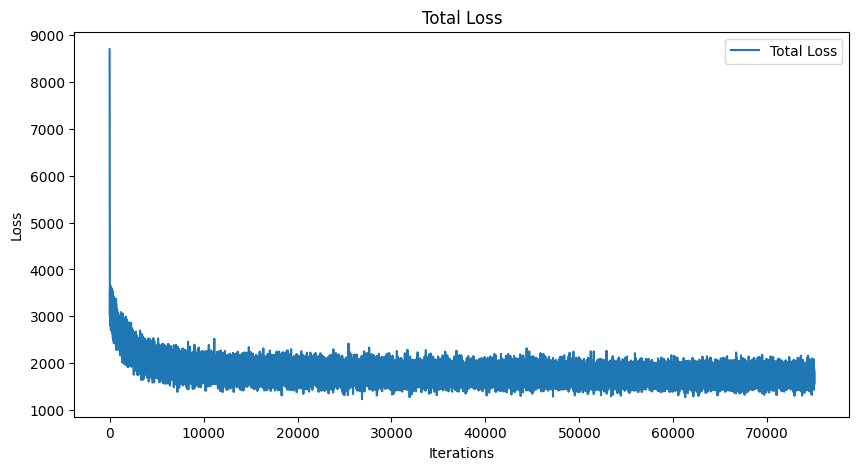

In [31]:
# Plot the log of the loss history, KL divergence in one graph and reconstruction loss in another.

plt.figure(figsize=(10, 5))
plt.plot(kl_divergence_history, label='KL Divergence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Total Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.show()


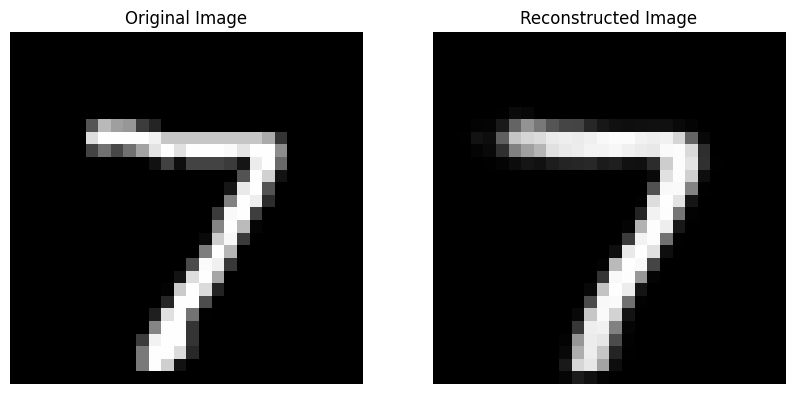

In [32]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


# Visualize latent vector reconstruction

torch.Size([8, 1, 28, 28])


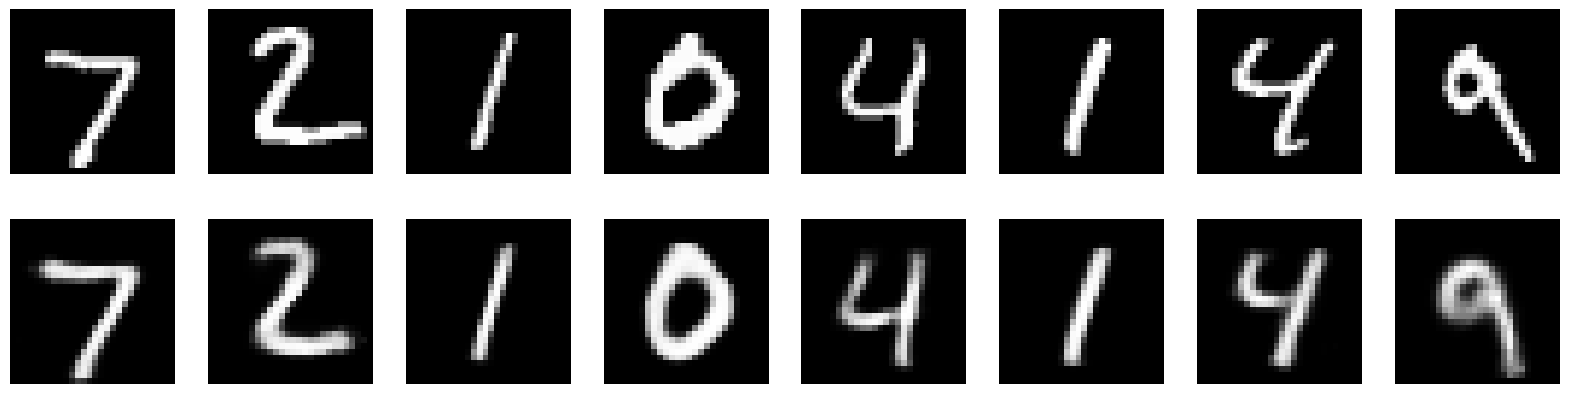

In [33]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:8].to(device)

    outputs, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

# Check if the model can denoise without explicitly training on noise data

In [34]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    mean (float): Mean of the Gaussian noise.
    std (float): Standard deviation of the Gaussian noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    """
    Adds salt and pepper noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    salt_prob (float): Probability of adding salt noise.
    pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noisy_images = images.clone()
    salt_mask = torch.rand_like(images) < salt_prob
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

def sample_value(mean, std):
    value = torch.randn(1) * std + mean
    return value.clamp(0, 1).item()

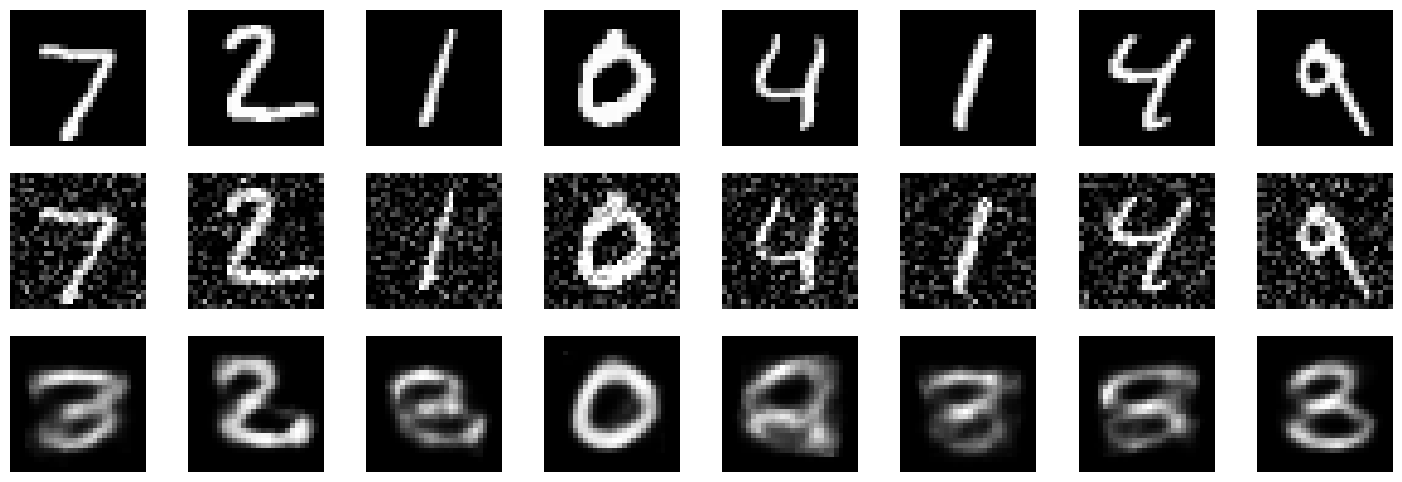

In [35]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.2, 0.2))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

Surprisingly, the model can denoise the images without being trained on noisy data.

# Sample from latent space

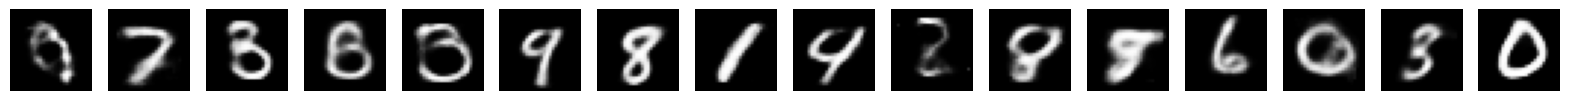

In [36]:
# Sample random latent vectors from a standard normal distribution
n_samples = 16

# Decode the latent vectors to generate images
vae.eval()
with torch.no_grad():
    # Epsilon is between 0 and 1, this is how we sample random latent vector
    epsilon = torch.randn(n_samples, latent_dim).to(device)
    generated_images = vae.decode(epsilon).cpu()

# Visualize the generated images
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))
for i in range(n_samples):
    axes[i].imshow(generated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()

# Train on noisy data

In [37]:
# Training loop
num_epochs = 20

loss_history = []
kl_divergence_history = []
recon_loss_history = []

for epoch in range(num_epochs):
    model.train()

    overall_loss = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            # Add gaussian noise
            images = add_gaussian_noise(images, std=sample_value(0.2, 0.2))

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            x_hat, mean, log_var = model(images)

            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

            # Add all three losses to history
            loss_history.append(loss.item())
            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())

            overall_loss += loss.item()

            # Propagate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            t.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
    print("Average loss: ", overall_loss / len(train_loader))


Epoch [1/20]: 100%|██████████| 3750/3750 [00:28<00:00, 133.36it/s, kl_loss=311, loss=2.15e+3, recon_loss=1.84e+3]


Epoch [1/20], Recon Loss: 4677.9855, KL Loss: 205.7174
Average loss:  4883.7029274088545


Epoch [2/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.94it/s, kl_loss=214, loss=4.61e+3, recon_loss=4.39e+3]


Epoch [2/20], Recon Loss: 4563.8050, KL Loss: 209.8876
Average loss:  4663.6822600911455


Epoch [3/20]: 100%|██████████| 3750/3750 [00:28<00:00, 133.62it/s, kl_loss=181, loss=6.15e+3, recon_loss=5.97e+3]


Epoch [3/20], Recon Loss: 4480.5030, KL Loss: 213.7386
Average loss:  4535.339548893229


Epoch [4/20]: 100%|██████████| 3750/3750 [00:28<00:00, 132.72it/s, kl_loss=190, loss=8.1e+3, recon_loss=7.9e+3]  


Epoch [4/20], Recon Loss: 4435.9898, KL Loss: 216.5586
Average loss:  4527.468768001302


Epoch [5/20]: 100%|██████████| 3750/3750 [00:27<00:00, 138.25it/s, kl_loss=200, loss=5.26e+3, recon_loss=5.06e+3]


Epoch [5/20], Recon Loss: 4411.2855, KL Loss: 218.6480
Average loss:  4539.474187858073


Epoch [6/20]: 100%|██████████| 3750/3750 [00:27<00:00, 137.37it/s, kl_loss=195, loss=6.08e+3, recon_loss=5.88e+3]


Epoch [6/20], Recon Loss: 4388.5600, KL Loss: 220.5005
Average loss:  4504.695517871094


Epoch [7/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.32it/s, kl_loss=195, loss=5.54e+3, recon_loss=5.35e+3]


Epoch [7/20], Recon Loss: 4371.8160, KL Loss: 221.9479
Average loss:  4501.984310872396


Epoch [8/20]: 100%|██████████| 3750/3750 [00:26<00:00, 142.84it/s, kl_loss=317, loss=1.94e+3, recon_loss=1.62e+3]


Epoch [8/20], Recon Loss: 4359.2494, KL Loss: 223.2399
Average loss:  4503.566587727864


Epoch [9/20]: 100%|██████████| 3750/3750 [00:27<00:00, 134.75it/s, kl_loss=300, loss=1.9e+3, recon_loss=1.6e+3]  


Epoch [9/20], Recon Loss: 4348.6994, KL Loss: 224.2259
Average loss:  4496.41417578125


Epoch [10/20]: 100%|██████████| 3750/3750 [00:27<00:00, 138.40it/s, kl_loss=209, loss=4.78e+3, recon_loss=4.57e+3]


Epoch [10/20], Recon Loss: 4338.5902, KL Loss: 225.1889
Average loss:  4481.462269856771


Epoch [11/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.87it/s, kl_loss=316, loss=2.02e+3, recon_loss=1.71e+3]


Epoch [11/20], Recon Loss: 4331.0232, KL Loss: 225.9923
Average loss:  4489.380638671875


Epoch [12/20]: 100%|██████████| 3750/3750 [00:27<00:00, 136.28it/s, kl_loss=183, loss=7.04e+3, recon_loss=6.85e+3]


Epoch [12/20], Recon Loss: 4322.2222, KL Loss: 226.7783
Average loss:  4460.835245865886


Epoch [13/20]: 100%|██████████| 3750/3750 [00:27<00:00, 138.72it/s, kl_loss=201, loss=7.97e+3, recon_loss=7.77e+3]


Epoch [13/20], Recon Loss: 4318.7174, KL Loss: 227.3622
Average loss:  4511.027665397135


Epoch [14/20]: 100%|██████████| 3750/3750 [00:26<00:00, 142.95it/s, kl_loss=254, loss=3.52e+3, recon_loss=3.27e+3]


Epoch [14/20], Recon Loss: 4313.8294, KL Loss: 227.9598
Average loss:  4486.014792578125


Epoch [15/20]: 100%|██████████| 3750/3750 [00:26<00:00, 144.06it/s, kl_loss=212, loss=5.2e+3, recon_loss=4.98e+3] 


Epoch [15/20], Recon Loss: 4303.8070, KL Loss: 228.6125
Average loss:  4401.243164420573


Epoch [16/20]: 100%|██████████| 3750/3750 [00:27<00:00, 135.39it/s, kl_loss=180, loss=6.93e+3, recon_loss=6.75e+3]


Epoch [16/20], Recon Loss: 4304.0168, KL Loss: 229.0252
Average loss:  4542.3794631835935


Epoch [17/20]: 100%|██████████| 3750/3750 [00:26<00:00, 141.49it/s, kl_loss=195, loss=6.19e+3, recon_loss=6e+3]   


Epoch [17/20], Recon Loss: 4299.8455, KL Loss: 229.4700
Average loss:  4469.691922688802


Epoch [18/20]: 100%|██████████| 3750/3750 [00:26<00:00, 143.15it/s, kl_loss=195, loss=6.49e+3, recon_loss=6.3e+3] 


Epoch [18/20], Recon Loss: 4293.7491, KL Loss: 229.9455
Average loss:  4428.139529329427


Epoch [19/20]: 100%|██████████| 3750/3750 [00:25<00:00, 145.74it/s, kl_loss=307, loss=1.89e+3, recon_loss=1.58e+3]


Epoch [19/20], Recon Loss: 4288.3619, KL Loss: 230.3894
Average loss:  4429.771113769531


Epoch [20/20]: 100%|██████████| 3750/3750 [00:25<00:00, 145.22it/s, kl_loss=233, loss=4.89e+3, recon_loss=4.66e+3]

Epoch [20/20], Recon Loss: 4287.2061, KL Loss: 230.6902
Average loss:  4501.651570084636


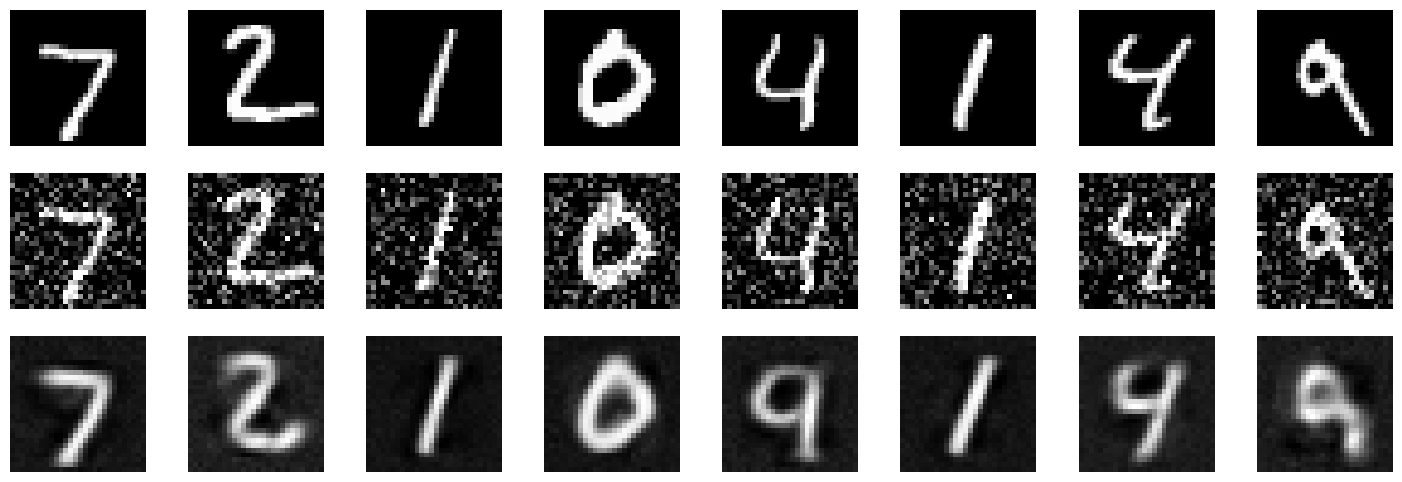

In [38]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.3, 0.1))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

Test on original reconstruction

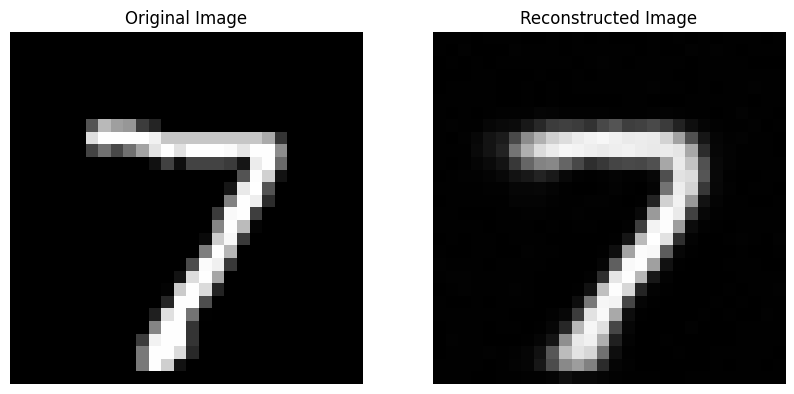

In [39]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


Still looking good

# Linear interpolation between two latent vectors

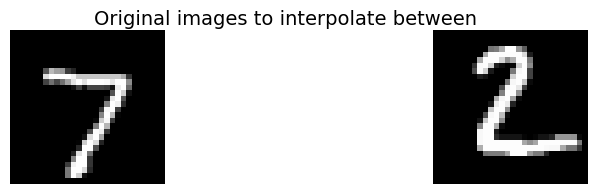

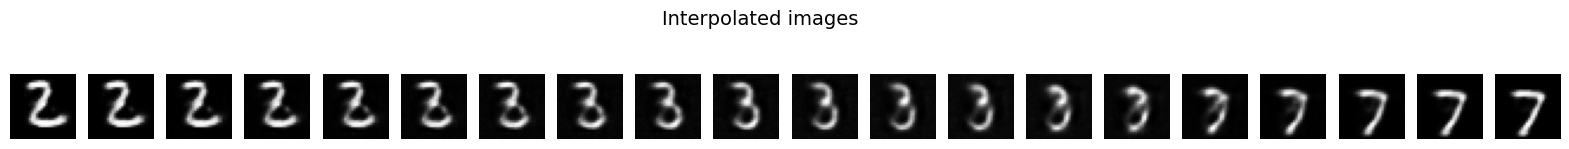

In [40]:
# Select two images from dataset
image1, _ = test_dataset[0]
image2, _ = test_dataset[1]

# Plot the two original images
fig, axes = plt.subplots(1, 2, figsize=(10, 2))
axes[0].imshow(image1.view(28, 28), cmap='gray')
axes[0].axis('off')
axes[1].imshow(image2.view(28, 28), cmap='gray')
axes[1].axis('off')
fig.suptitle("Original images to interpolate between", fontsize=14)
plt.show()

# Get the latent vectors of the images
model.eval()
with torch.no_grad():
    image1 = image1.unsqueeze(0).to(device)
    image2 = image2.unsqueeze(0).to(device)

    mean, log_var = model.encode(image1)
    z1 = model.reparameterization(mean, torch.exp(0.5 * log_var))

    mean, log_var = model.encode(image2)
    z2 = model.reparameterization(mean, torch.exp(0.5 * log_var))

    # Interpolate between the two latent vectors
    n_steps = 20
    latent_vectors = []
    for alpha in np.linspace(0, 1, n_steps):
        latent_vector = alpha * z1 + (1 - alpha) * z2 # Linear interpolation
        latent_vectors.append(latent_vector)

    latent_vectors = torch.cat(latent_vectors, dim=0)
    interpolated_images = model.decode(latent_vectors).cpu()

# Visualize the interpolated images
fig, axes = plt.subplots(1, n_steps, figsize=(20, 2))
for i in range(n_steps):
    axes[i].imshow(interpolated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')
    fig.suptitle("Interpolated images", fontsize=14)
plt.show()


# Save model 'vae_model.pth'

In [41]:
# Save model
torch.save(model.state_dict(), "vae_model.pth")